<header> <h1> Code for Project Deliverable: Predicting round outcome in Counter Strike:® Global Offensive </h1>

<h2> <p style = "text-align:center;"> Importing relevant libraries and initializing our dataframe.  </h2> </header>

In [16]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
from tensorflow import keras
import seaborn as sns
from pathlib import Path 
from scipy.stats import norm
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
sigma = 8.3333

<header> <h2> <p style = "text-align:center;"> Running correlation analysis on our dataset.  </h2> </header>

In [4]:
df = pd.read_csv("csgo_round_snapshots.csv")

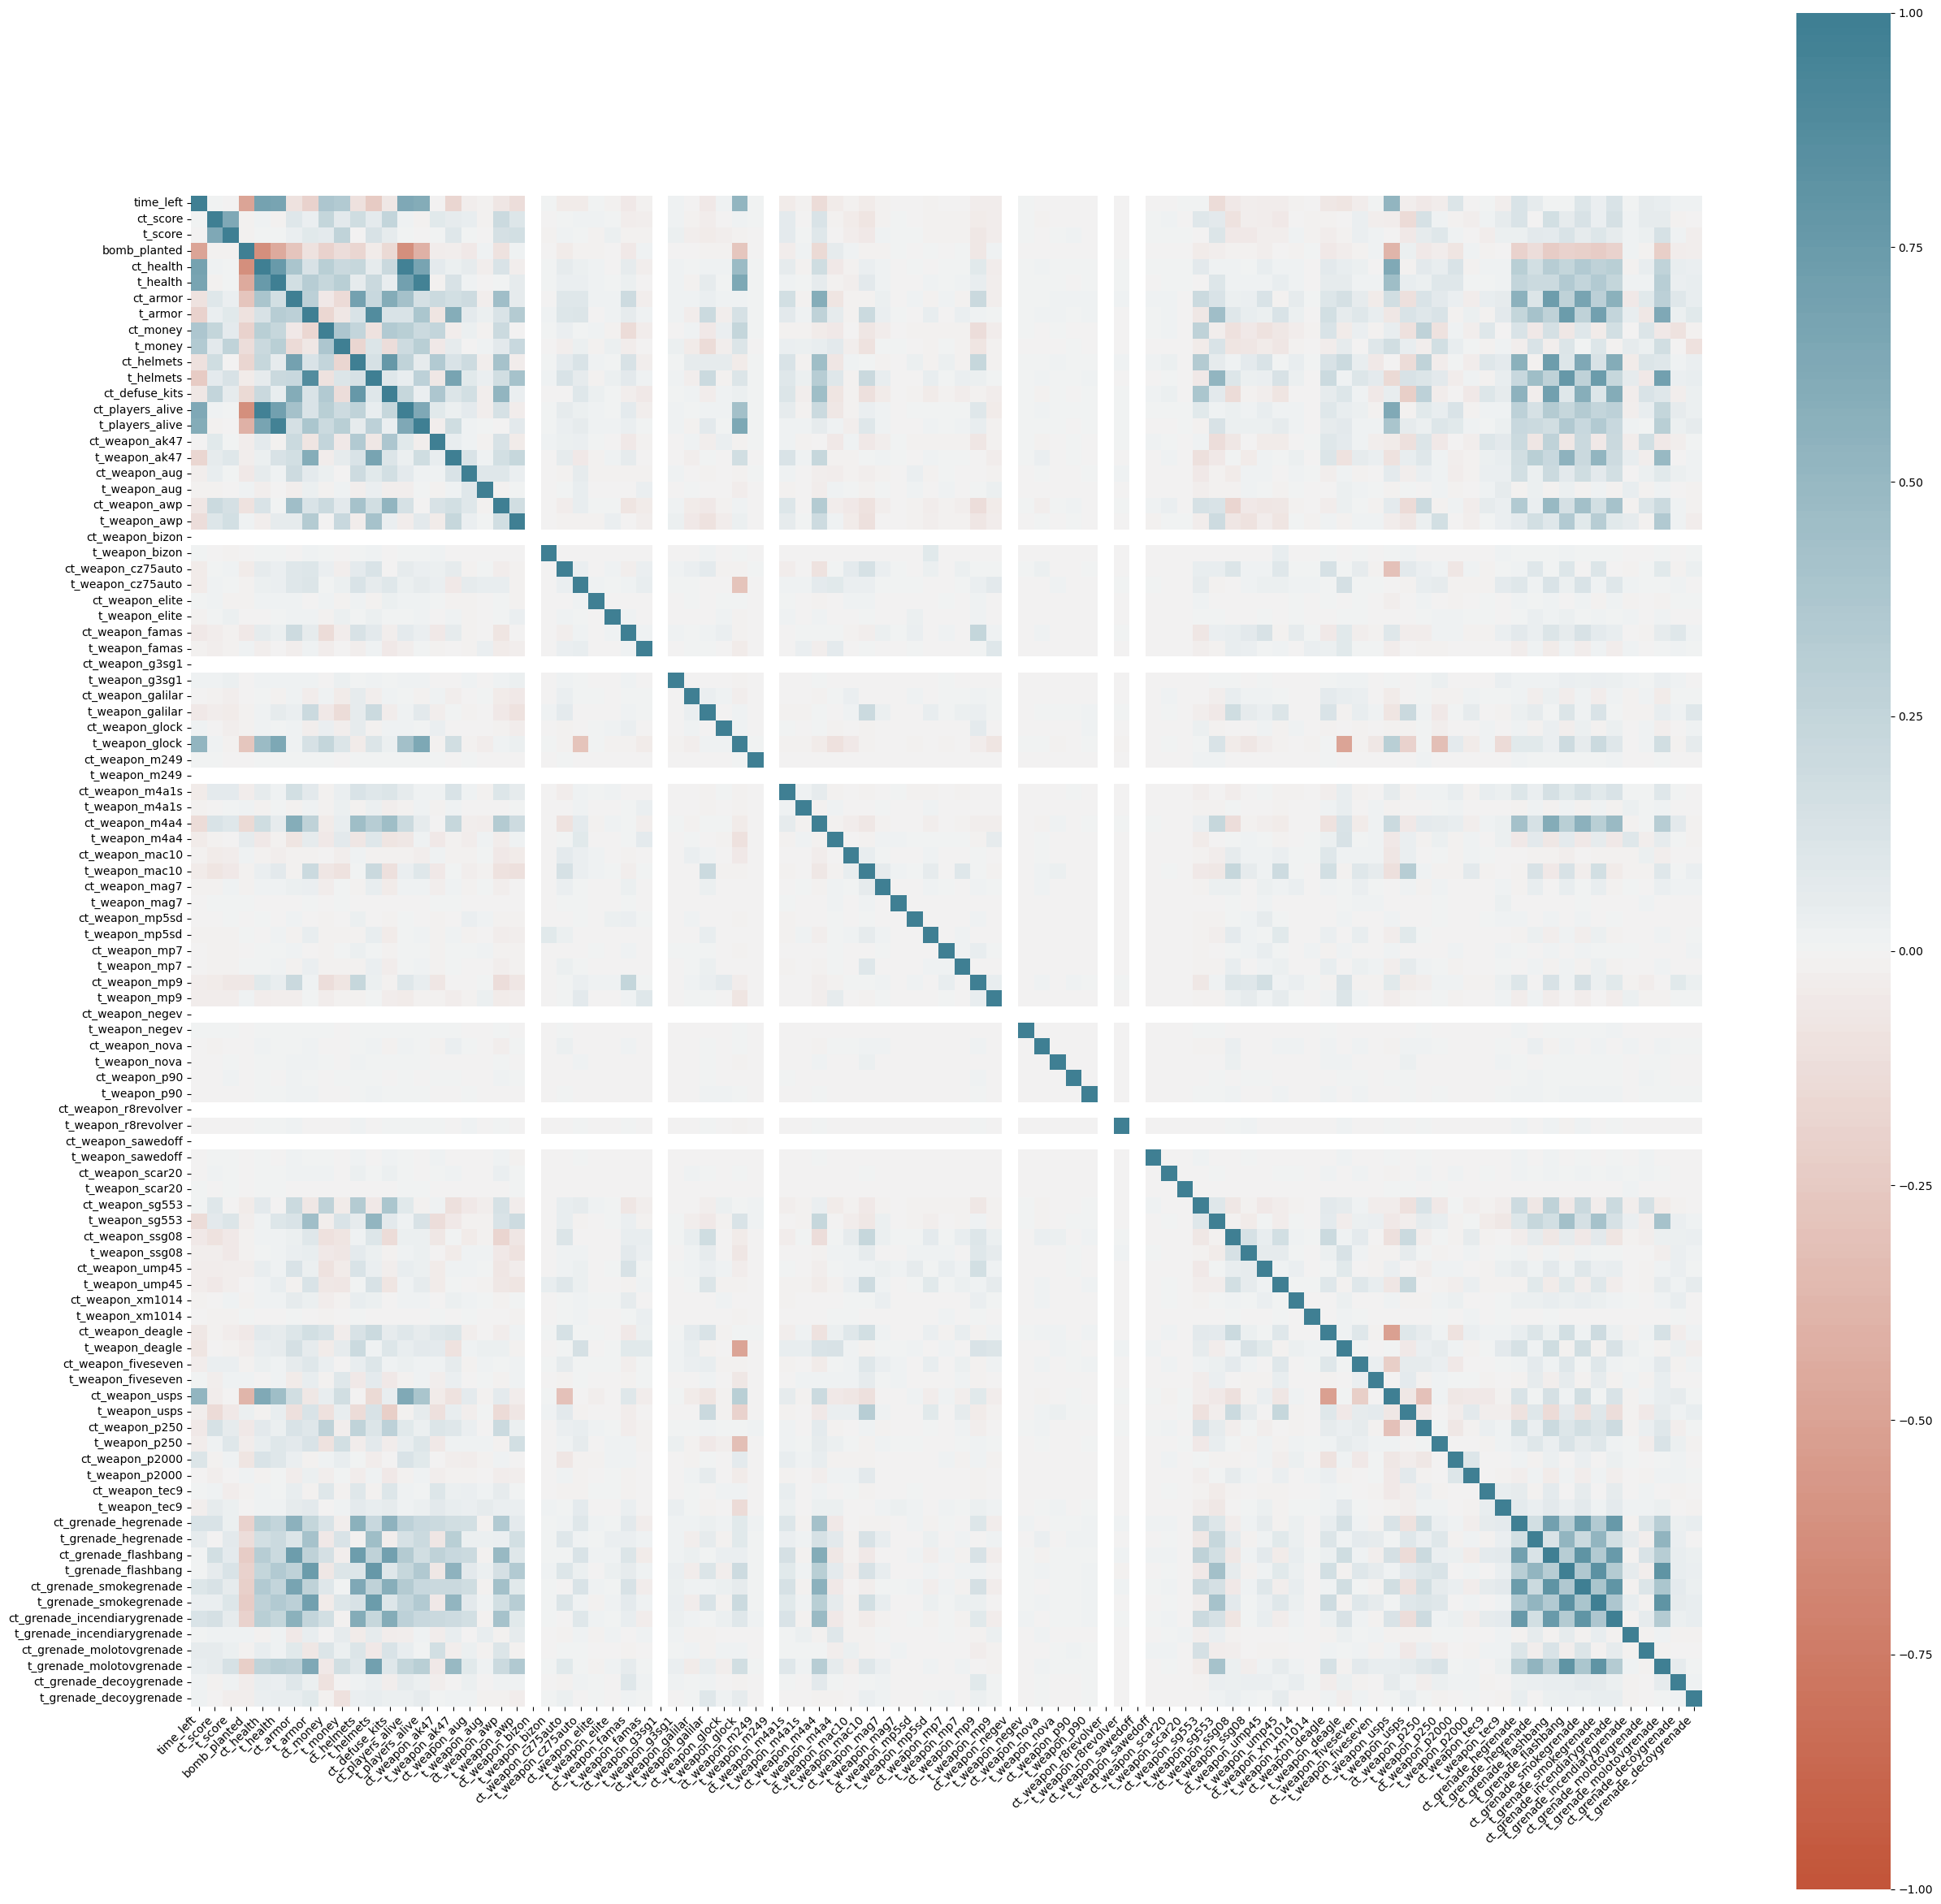

In [17]:
#acquired from: https://towardsdatascience.com/better-heatmaps-and-correlation-matrix-plots-in-python-41445d0f2bec
corr = df.corr()
plt.rcParams["figure.figsize"] = [30, 30]
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);
plt.savefig("FeatureCorrelation1.pdf", format="pdf", bbox_inches="tight")

<header> <h2> <p style = "text-align:center;"> Formatting our data.  </h2> </header>

In [31]:
#we are formatting our 'round_winner' column into integer values such that 'CT' = 0, 'T =1'.
#similarly for the 'bomb_planted':False = 0, True=1.
df.drop(columns=['t_weapon_mag7'])
for index in df.index:
    if df.loc[index,'round_winner'] == 'CT':
        df.loc[index,'round_winner'] = 0
    elif df.loc[index,'round_winner'] == 'T':
        df.loc[index,'round_winner'] = 1
    if df.loc[index,'bomb_planted'] == False:
        df.loc[index,'bomb_planted'] = 0
    elif df.loc[index,'bomb_planted'] == True:
        df.loc[index,'bomb_planted'] = 1


<p>Deleting possible outliers and superfluous labels</p>

In [6]:
for index in df.index:
    if df.at[index ,'ct_grenade_decoygrenade'] > 0:
        df.drop([index],inplace = True)
    elif df.at[index ,'t_grenade_decoygrenade'] > 0:
        df.drop([index],inplace = True)
    elif df.at[index,'t_weapon_r8revolver'] > 0:
        df.drop([index],inplace = True)
    elif df.loc[index,'ct_weapon_r8revolver'] > 0:
        df.drop([index],inplace = True)
        

In [7]:
df.drop(columns=['t_grenade_decoygrenade','ct_grenade_decoygrenade','ct_weapon_r8revolver','t_weapon_r8revolver'],inplace = True)

In [8]:
df.reset_index(drop=True,inplace=True)

<p> Adding TrueSkill Metric to our dataset </p>

In [9]:
df.insert(92,"TrueSkill",[norm.cdf((df.at[index,'t_score']-df.at[index,'ct_score'])/np.sqrt(2*sigma**2)) for index in df.index])

In [10]:
df.drop(columns=['map'],inplace = True)

In [13]:
df

,time_left,ct_score,t_score,bomb_planted,ct_health,t_health,ct_armor,t_armor,ct_money,t_money,...,ct_grenade_flashbang,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,TrueSkill,round_winner
0,175.00,0.0,0.0,0,500.0,500.0,0.0,0.0,4000.0,4000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500000,0
1,156.03,0.0,0.0,0,500.0,500.0,400.0,300.0,600.0,650.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.500000,0
2,96.03,0.0,0.0,0,391.0,400.0,294.0,200.0,750.0,500.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.500000,0
3,76.03,0.0,0.0,0,391.0,400.0,294.0,200.0,750.0,500.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500000,0
4,174.97,1.0,0.0,0,500.0,500.0,192.0,0.0,18350.0,10750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.466189,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116190,15.41,11.0,14.0,1,200.0,242.0,195.0,359.0,100.0,5950.0,...,1.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.600468,1
116191,174.93,11.0,15.0,0,500.0,500.0,95.0,175.0,11500.0,23900.0,...,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.632851,1
116192,114.93,11.0,15.0,0,500.0,500.0,495.0,475.0,1200.0,6700.0,...,4.0,4.0,3.0,5.0,1.0,0.0,0.0,5.0,0.632851,1
116193,94.93,11.0,15.0,0,500.0,500.0,495.0,475.0,1200.0,6700.0,...,1.0,5.0,0.0,3.0,0.0,0.0,0.0,4.0,0.632851,1


<header> <h2> <p style = "text-align:center;"> Splitting the data.  </h2> </header>

In [40]:
df['bomb_planted'] = pd.to_numeric(df['bomb_planted'])
X = df.iloc[:,0:91] #Features
y = df.iloc[:,92]   #Labels

y=y.astype('int')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify = y)

<header> <h2> <p style = "text-align:center;"> Training: HistGradientBoost Classifier.  </h2> </header>

In [134]:
HGB_GS = HistGradientBoostingClassifier()
HGB_search_space = {
    "learning_rate" : [10**-3, 10**-2, 10**-1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,1],
    "max_iter"      : [100,500,1000,1500]
    
}

GS_HGB = GridSearchCV(estimator = HGB_GS, param_grid = HGB_search_space, scoring = ["accuracy"], refit = "accuracy",
                      error_score = 'raise',cv = 5, verbose = 4)
GS_HGB.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV 1/5] END learning_rate=0.001, max_iter=100; accuracy: (test=0.723) total time=   2.3s
[CV 2/5] END learning_rate=0.001, max_iter=100; accuracy: (test=0.730) total time=   2.1s
[CV 3/5] END learning_rate=0.001, max_iter=100; accuracy: (test=0.731) total time=   2.3s
[CV 4/5] END learning_rate=0.001, max_iter=100; accuracy: (test=0.728) total time=   2.1s
[CV 5/5] END learning_rate=0.001, max_iter=100; accuracy: (test=0.728) total time=   2.0s
[CV 1/5] END learning_rate=0.001, max_iter=500; accuracy: (test=0.744) total time=   8.4s
[CV 2/5] END learning_rate=0.001, max_iter=500; accuracy: (test=0.749) total time=   8.9s
[CV 3/5] END learning_rate=0.001, max_iter=500; accuracy: (test=0.752) total time=   8.5s
[CV 4/5] END learning_rate=0.001, max_iter=500; accuracy: (test=0.757) total time=   8.6s
[CV 5/5] END learning_rate=0.001, max_iter=500; accuracy: (test=0.747) total time=   8.9s
[CV 1/5] END learning_rate=0.001, max_

[CV 3/5] END learning_rate=0.3, max_iter=1000; accuracy: (test=0.795) total time=   2.3s
[CV 4/5] END learning_rate=0.3, max_iter=1000; accuracy: (test=0.789) total time=   1.3s
[CV 5/5] END learning_rate=0.3, max_iter=1000; accuracy: (test=0.809) total time=   3.9s
[CV 1/5] END learning_rate=0.3, max_iter=1500; accuracy: (test=0.796) total time=   3.2s
[CV 2/5] END learning_rate=0.3, max_iter=1500; accuracy: (test=0.814) total time=   3.4s
[CV 3/5] END learning_rate=0.3, max_iter=1500; accuracy: (test=0.803) total time=   2.6s
[CV 4/5] END learning_rate=0.3, max_iter=1500; accuracy: (test=0.823) total time=   4.5s
[CV 5/5] END learning_rate=0.3, max_iter=1500; accuracy: (test=0.805) total time=   3.6s
[CV 1/5] END learning_rate=0.4, max_iter=100; accuracy: (test=0.785) total time=   1.9s
[CV 2/5] END learning_rate=0.4, max_iter=100; accuracy: (test=0.800) total time=   2.0s
[CV 3/5] END learning_rate=0.4, max_iter=100; accuracy: (test=0.791) total time=   2.0s
[CV 4/5] END learning_ra

[CV 1/5] END learning_rate=0.8, max_iter=500; accuracy: (test=0.763) total time=   0.7s
[CV 2/5] END learning_rate=0.8, max_iter=500; accuracy: (test=0.774) total time=   0.8s
[CV 3/5] END learning_rate=0.8, max_iter=500; accuracy: (test=0.768) total time=   0.8s
[CV 4/5] END learning_rate=0.8, max_iter=500; accuracy: (test=0.777) total time=   0.9s
[CV 5/5] END learning_rate=0.8, max_iter=500; accuracy: (test=0.769) total time=   0.9s
[CV 1/5] END learning_rate=0.8, max_iter=1000; accuracy: (test=0.761) total time=   0.8s
[CV 2/5] END learning_rate=0.8, max_iter=1000; accuracy: (test=0.771) total time=   0.8s
[CV 3/5] END learning_rate=0.8, max_iter=1000; accuracy: (test=0.775) total time=   0.9s
[CV 4/5] END learning_rate=0.8, max_iter=1000; accuracy: (test=0.774) total time=   0.8s
[CV 5/5] END learning_rate=0.8, max_iter=1000; accuracy: (test=0.765) total time=   0.8s
[CV 1/5] END learning_rate=0.8, max_iter=1500; accuracy: (test=0.755) total time=   0.8s
[CV 2/5] END learning_rate

GridSearchCV(cv=5, error_score='raise',
             estimator=HistGradientBoostingClassifier(),
             param_grid={'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5,
                                           0.6, 0.7, 0.8, 0.9, 1],
                         'max_iter': [100, 500, 1000, 1500]},
             refit='accuracy', scoring=['accuracy'], verbose=4)

In [136]:
print(GS_HGB.best_params_)
print('The best score from GS is: ', GS_HGB.best_score_)

{'learning_rate': 0.1, 'max_iter': 1500}
The best score from GS is:  0.8153163891114736


In [137]:
HGBTestAcc = GS_HGB.best_estimator_.score(X_test, y_test)
print('Final test set accuracy: ', HGBTestAcc*100)

Final test set accuracy:  83.94675693508132


<header> <h2> <p style = "text-align:center;"> Training: RandomForest Classifier.  </h2> </header>

In [142]:
RF_search_space = {
    "n_estimators" : [50,100,120,140,160,180,200,250]
}

GS_RF = GridSearchCV(estimator = RandomForestClassifier(), param_grid = RF_search_space, scoring = ["accuracy"], refit = "accuracy",
                      error_score = 'raise',cv = 5, verbose = 4)
GS_RF.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .........n_estimators=50; accuracy: (test=0.849) total time=   5.7s
[CV 2/5] END .........n_estimators=50; accuracy: (test=0.847) total time=   5.8s
[CV 3/5] END .........n_estimators=50; accuracy: (test=0.852) total time=   5.5s
[CV 4/5] END .........n_estimators=50; accuracy: (test=0.846) total time=   5.7s
[CV 5/5] END .........n_estimators=50; accuracy: (test=0.846) total time=   5.9s
[CV 1/5] END ........n_estimators=100; accuracy: (test=0.851) total time=  11.0s
[CV 2/5] END ........n_estimators=100; accuracy: (test=0.851) total time=  11.3s
[CV 3/5] END ........n_estimators=100; accuracy: (test=0.859) total time=  11.5s
[CV 4/5] END ........n_estimators=100; accuracy: (test=0.854) total time=  11.5s
[CV 5/5] END ........n_estimators=100; accuracy: (test=0.851) total time=  11.3s
[CV 1/5] END ........n_estimators=120; accuracy: (test=0.853) total time=  13.4s
[CV 2/5] END ........n_estimators=120; accuracy: 

GridSearchCV(cv=5, error_score='raise', estimator=RandomForestClassifier(),
             param_grid={'n_estimators': [50, 100, 120, 140, 160, 180, 200,
                                          250]},
             refit='accuracy', scoring=['accuracy'], verbose=4)

In [143]:
print(GS_RF.best_params_)
print('The best score from GS is: ', GS_RF.best_score_)

{'n_estimators': 200}
The best score from GS is:  0.856570304109915


In [144]:
RFTestAcc = GS_RF.best_estimator_.score(X_test, y_test)
print('Final test set accuracy: ', RFTestAcc*100)

Final test set accuracy:  86.54866748902722


<header> <h2> <p style = "text-align:center;"> Training: Logistic Regression Classifier.  </h2> </header>

In [152]:
LogReg_search_space = {
    "C"        : [10**-2, 10**-1, 1, 10**1, 10**2],
    "max_iter" : [900,1000,1100,1200,1300,1500]
}

GS_LogReg = GridSearchCV(estimator = LogisticRegression(solver = 'liblinear', penalty = 'l1'), param_grid = LogReg_search_space, scoring = ["accuracy"], refit = "accuracy", cv = 5, verbose = 4)
GS_LogReg.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 1/5] END ....C=0.01, max_iter=900; accuracy: (test=0.756) total time=   3.9s
[CV 2/5] END ....C=0.01, max_iter=900; accuracy: (test=0.748) total time=   3.5s
[CV 3/5] END ....C=0.01, max_iter=900; accuracy: (test=0.753) total time=   3.2s
[CV 4/5] END ....C=0.01, max_iter=900; accuracy: (test=0.753) total time=   3.7s
[CV 5/5] END ....C=0.01, max_iter=900; accuracy: (test=0.750) total time=   4.0s
[CV 1/5] END ...C=0.01, max_iter=1000; accuracy: (test=0.756) total time=   3.8s
[CV 2/5] END ...C=0.01, max_iter=1000; accuracy: (test=0.748) total time=   3.7s
[CV 3/5] END ...C=0.01, max_iter=1000; accuracy: (test=0.753) total time=   4.5s
[CV 4/5] END ...C=0.01, max_iter=1000; accuracy: (test=0.753) total time=   3.6s
[CV 5/5] END ...C=0.01, max_iter=1000; accuracy: (test=0.750) total time=   5.4s
[CV 1/5] END ...C=0.01, max_iter=1100; accuracy: (test=0.756) total time=   2.4s
[CV 2/5] END ...C=0.01, max_iter=1100; accuracy

[CV 2/5] END .....C=10, max_iter=1100; accuracy: (test=0.749) total time=  10.1s
[CV 3/5] END .....C=10, max_iter=1100; accuracy: (test=0.751) total time=   6.4s
[CV 4/5] END .....C=10, max_iter=1100; accuracy: (test=0.753) total time=  13.4s
[CV 5/5] END .....C=10, max_iter=1100; accuracy: (test=0.747) total time=   7.7s
[CV 1/5] END .....C=10, max_iter=1200; accuracy: (test=0.756) total time=   5.1s
[CV 2/5] END .....C=10, max_iter=1200; accuracy: (test=0.748) total time=   4.7s
[CV 3/5] END .....C=10, max_iter=1200; accuracy: (test=0.751) total time=   5.9s
[CV 4/5] END .....C=10, max_iter=1200; accuracy: (test=0.752) total time=   9.8s
[CV 5/5] END .....C=10, max_iter=1200; accuracy: (test=0.747) total time=  21.1s
[CV 1/5] END .....C=10, max_iter=1300; accuracy: (test=0.756) total time=   9.0s
[CV 2/5] END .....C=10, max_iter=1300; accuracy: (test=0.749) total time=   6.1s
[CV 3/5] END .....C=10, max_iter=1300; accuracy: (test=0.751) total time=   5.3s
[CV 4/5] END .....C=10, max_

GridSearchCV(cv=5,
             estimator=LogisticRegression(penalty='l1', solver='liblinear'),
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'max_iter': [900, 1000, 1100, 1200, 1300, 1500]},
             refit='accuracy', scoring=['accuracy'], verbose=4)

In [153]:
print(GS_LogReg.best_params_)
print('The best score from GS is: ', GS_LogReg.best_score_)

{'C': 0.01, 'max_iter': 1300}
The best score from GS is:  0.7521884026559553


In [154]:
LogRegTestAcc = GS_LogReg.best_estimator_.score(X_test, y_test)
print('Final test set accuracy: ', LogRegTestAcc*100)

Final test set accuracy:  75.51564875641871


<header> <h2> <p style = "text-align:center;"> Training: K-NN Classifier.  </h2> </header>

In [157]:
KNN_search_space = {
    "n_neighbors" : [1,2,3,4,5,6,7,8,10,20]
}
GS_KNN = GridSearchCV(estimator = KNeighborsClassifier(), param_grid = KNN_search_space, scoring = ["accuracy"], refit = "accuracy", cv = 5, verbose = 4)
GS_KNN.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END ...........n_neighbors=1; accuracy: (test=0.789) total time=  12.8s
[CV 2/5] END ...........n_neighbors=1; accuracy: (test=0.784) total time=  12.1s
[CV 3/5] END ...........n_neighbors=1; accuracy: (test=0.786) total time=  12.4s
[CV 4/5] END ...........n_neighbors=1; accuracy: (test=0.785) total time=  12.1s
[CV 5/5] END ...........n_neighbors=1; accuracy: (test=0.783) total time=  12.0s
[CV 1/5] END ...........n_neighbors=2; accuracy: (test=0.752) total time=  13.2s
[CV 2/5] END ...........n_neighbors=2; accuracy: (test=0.745) total time=  13.4s
[CV 3/5] END ...........n_neighbors=2; accuracy: (test=0.747) total time=  13.6s
[CV 4/5] END ...........n_neighbors=2; accuracy: (test=0.747) total time=  13.3s
[CV 5/5] END ...........n_neighbors=2; accuracy: (test=0.743) total time=  13.7s
[CV 1/5] END ...........n_neighbors=3; accuracy: (test=0.755) total time=  14.0s
[CV 2/5] END ...........n_neighbors=3; accuracy:

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 10, 20]},
             refit='accuracy', scoring=['accuracy'], verbose=4)

In [158]:
print(GS_KNN.best_params_)
print('The best score from GS is: ', GS_KNN.best_score_*100)

{'n_neighbors': 1}
The best score from GS is:  78.53594542594912


In [159]:
KNN_TestAcc = GS_KNN.best_estimator_.score(X_test, y_test)
print('Final test set accuracy: ', KNN_TestAcc*100)

Final test set accuracy:  80.66209587194125


<header> <h2> <p style = "text-align:center;"> Training: Multilayer Perceptron Classifier.  </h2> </header>

<header> <h3> Splitting data into train, validation, and test.</h3> </header>

In [79]:

X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.2, random_state=3, stratify = y)
X_train1, X_valid1, y_train1, y_valid1 = train_test_split(X_train1, y_train1, test_size = 0.25, random_state=3)

In [80]:
MLP = keras.Sequential()
MLP.add(Dense(100, activation = "relu", input_dim =91,name='layer1'))
MLP.add(Dense(100, activation ="relu",name='layer2'))
MLP.add(Dense(1, activation="sigmoid",name='output')) 
MLP.summary()


Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 100)               9200      
                                                                 
 layer2 (Dense)              (None, 100)               10100     
                                                                 
 output (Dense)              (None, 1)                 101       
                                                                 
Total params: 19,401
Trainable params: 19,401
Non-trainable params: 0
_________________________________________________________________


In [81]:
MLP.compile(optimizer="Adam", loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',patience = 5, verbose = 1,restore_best_weights = True)
callbacks_list = [early_stop]
MLP.fit(X_train1, y_train1, epochs=50, validation_data = (X_valid1, y_valid1))
MLP_valid_loss,MLP_valid_accuracy = MLP.evaluate(X_valid1, y_valid1)

Epoch 1/50
2179/2179 [==============================] - 11s 5ms/step - loss: 17.7466 - accuracy: 0.6594 - val_loss: 7.1871 - val_accuracy: 0.7187
Epoch 2/50
2179/2179 [==============================] - 10s 5ms/step - loss: 6.4816 - accuracy: 0.6803 - val_loss: 3.3742 - val_accuracy: 0.7058
Epoch 3/50
2179/2179 [==============================] - 10s 5ms/step - loss: 3.9292 - accuracy: 0.6861 - val_loss: 4.0555 - val_accuracy: 0.6481
Epoch 4/50
2179/2179 [==============================] - 10s 4ms/step - loss: 2.1935 - accuracy: 0.6881 - val_loss: 1.0837 - val_accuracy: 0.7163
Epoch 5/50
2179/2179 [==============================] - 10s 5ms/step - loss: 1.4740 - accuracy: 0.6917 - val_loss: 3.8749 - val_accuracy: 0.5833
Epoch 6/50
2179/2179 [==============================] - 10s 5ms/step - loss: 0.9691 - accuracy: 0.7010 - val_loss: 0.5839 - val_accuracy: 0.7328
Epoch 7/50
2179/2179 [==============================] - 10s 5ms/step - loss: 0.7510 - accuracy: 0.7078 - val_loss: 0.5065 - val_a

In [71]:
MLP_test_loss, MLP_test_accuracy = MLP.evaluate(X_test1, y_test1)
print('Accuracy: %.2f' % (MLP_test_accuracy*100))

1090/1090 [==============================] - 3s 3ms/step - loss: 0.4871 - accuracy: 0.7519
Accuracy: 75.19
